# Exercícios de Fixação de Conceitos 1

### Índice
- [Definição do problema de classificação](#definicao_problema)
- [*Dataset*: consideraçõs e análise](#dataset_consideracoes_analise)
    - [Estrutura do *dataset*](#estrutura_dataset)
    - [Distribuição de frequências em função das classes (Histograma)](#dist_frequencias_histograma)
    - [Visualização de imagens de dígitos manuscritos](#visualizacao_imagens)
- [Conjuntos de treinamento e validação](#conjunto_treinamento_validacao)
    - [Validação cruzada](#validacao_cruzada)
    - [Dados balanceados e representativos](#dados_balanceados_representativos)
- [Classificador Linear](#modelo_linear)
    - [Modelo de Regressão Linear](#modelo_regressao)
    - [Considerações para utilizar o modelo de Regressão como Classificador Linear](#consideracoes)
    - [Parâmetros de desempenho](#param_desempenho)
- [Resolução do problema](#resolucao)
    - [Etapa de treinamento e validação - Busca inicial](#busca_inicial)
        - [Treinamento e validação](#A1)
        - [Melhores coeficientes de regularização obtidos](#A2)
        - [Gráfico semilog do desempenho dos classificadores junto aos dados de validação considerando o erro quadrático médio](#A3)
        - [Gráfico semilog do desempenho dos classificadores junto aos dados de validação consideranda taxa de classificação correta](#A4)
        - [Gráfico semilog do desempenho dos classificadores junto aos dados de validação consideranda taxa de erro de classificação](#A5)
    - [Etapa de treinamento e validação - Busca refinada considerando o erro quadrático médio](#busca_refinada_MSE)
        - [Treinamento e validação](#B1)
        - [Melhor coeficiente de regularização obtido](#B2)
        - [Gráfico semilog do desempenho dos classificadores junto aos dados de validação considerando o erro quadrático médio](#B3)
    - [Etapa de treinamento e validação - Busca refinada considerando o erro de classificação](#busca_refinada_CE)
        - [Treinamento e validação](#C1)
        - [Melhor coeficiente de regularização obtido](#C2)
        - [Gráfico semilog do desempenho dos classificadores junto aos dados de validação consideranda taxa de classificação correta](#C3)
        - [Gráfico semilog do desempenho dos classificadores junto aos dados de validação consideranda taxa de erro de classificação](#C4)
    - [Etapa de teste](#teste)
        - [Treinamento e teste](#D1)
        - [Matriz de Confusão](#D2)
        - [Matriz de parâmetros](#D3)
        - [Gráficos de calor para os parâmetros de cada um dos 10 classificadores lineares](#D4)
        - [Exemplos de dígitos classificados incorretamente](#D5)

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
def onehot_to_categorical(y_onehot):
    aux = y_onehot.argmax()
    if aux < 9:
        return aux + 1
    else:
        return 0

In [3]:
def plot_hist(y_categorical, titleText, ymax, step):
    plt.figure(figsize=(8,4))
    
    plt.xlabel('Classes')
    plt.ylabel('Frequência')
    plt.xticks(range(0,10))
    plt.yticks(range(0, ymax, step))

    plt.title(titleText)
    #plt.grid(True, axis='y')

    a = plt.hist(y_categorical, range=(-0.5, 9.5), bins=20, align='left', color='royalblue');
    return a

In [4]:
def plot_digit_images(X, Y_categorical, titlesText, Nimgs=5):
    plt.figure(figsize=(15,4))
    i = rn.randint(0, X.shape[0])

    for index, (image, label) in enumerate(zip(X[i:i+Nimgs], Y_categorical[i:i+Nimgs])):
        plt.subplot(1, Nimgs, index + 1)
        X_image = np.transpose(np.reshape(image, (28, 28)))
        plt.imshow(X_image, cmap='gray')
        plt.title(titlesText + f'{label}\n', fontsize = 12)

In [5]:
path = '../EFC1/dataset/'

data = scipy.io.loadmat(path + 'data.mat')
test = scipy.io.loadmat(path + 'test.mat')

X = data['X'] 
Y = data['S'] 

Xtest = test['Xt']
Ytest = test['St']

Y_categorical = np.array(tuple(map(onehot_to_categorical, Y)))
Ytest_categorical = np.array(tuple(map(onehot_to_categorical, Ytest)))

-------------------------------------------------------------
<a id="definicao_problema"></a>
### Definição do problema

- O objetivo deste exercício consiste em sintetizar modelos lineares para classificação de padrões.
- É utilizado o famoso *dataset* de imagens de dígitos manuscritos [MNIST](http://yann.lecun.com/exdb/mnist/), o qual contém 60.000 amostras para treinamento e 10.000 amostras para teste.
- Cada imagem de entrada contém 784 pixels (no intervalo [0, 255], correspondente a níveis de cinza), visto que a dimensão de cada uma delas é de 28x28 pixels.
- O problema de classificação investigado é do tipo multi-classe (10 classes), sendo que cada classe representa um dígito de 0 a 9.

-----------------------------------------------------------------
<a id="dataset_consideracoes_analise"></a>
### *Dataset*: Considerações e Análise

<a id="estrutura_dataset"></a>
- **Estrutura do** ***dataset*** **:**
    - Os dados de treinamento estão contidos nas matrizes $X$ e $Y$.
    
    - Matriz $X$:
        - Cada linha representa uma amostra de entrada (imagem).
        - Cada coluna contém um pixel da amostra de entrada.
        - Os valores de cada pixel foram normalizados de modo a apresentar valores no intervalo [0,1].
        - A dimensão da matriz $X$ é de 60.000x784 (Temos 60.000 amostras cada uma com 784 pixels).
        
    - Matriz $Y$:
        - Cada linha representa a saída desejada (e conhecida) para cada uma das amostras de entrada.
        - Cada saída está na representação *one-hot encoding*, isto é, só existe um elemento não nulo responsável por indicar a classe a qual a amostra pertence. Um exemplo dessa representação é dada durante a execução do código.
        - Cada coluna representa uma classe:
            - Colunas 0 a 8 representam as classes referentes aos dígitos 1 a 9, respectivamente.
            - Coluna 9 representa a classe referente ao dígito 0.
    
    - As matrizes $X_{test}$ e $Y_{test}$ do conjunto de teste possuem as mesmas características acima, mas com as seguintes dimensões:
        - A dimensão da matriz $X_{test}$ é de 10.000x784 (Temos 10.000 amostras cada uma com 784 pixels
        - A dimensão da matriz $Y_{test}$ é de 10.000x10.

In [6]:
print(f'Dimensão da matriz X: {X.shape}')
print(f'Dimensão da matriz Y: {Y.shape}')
print('--------------------------------------')
print(f'Dimensão da matriz Xtest: {Xtest.shape}')
print(f'Dimensão da matriz Ytest: {Ytest.shape}')

Dimensão da matriz X: (60000, 784)
Dimensão da matriz Y: (60000, 10)
--------------------------------------
Dimensão da matriz Xtest: (10000, 784)
Dimensão da matriz Ytest: (10000, 10)


In [7]:
n1 = rn.randint(0, Y.shape[0])
n2 = rn.randint(0, Ytest.shape[0])

print('Exemplo do conjunto de treinamento:')
print(f'Saída na representação one-hot encoding: {Y[n1]}')
print(f'Saída na representação categórica: {Y_categorical[n1]}')

print('--------------------------------------------------------------')

print('Exemplo do conjunto de teste:')
print(f'Saída na representação one-hot encoding: {Ytest[n2]}')
print(f'Saída na representação categórica: {Ytest_categorical[n2]}')

Exemplo do conjunto de treinamento:
Saída na representação one-hot encoding: [0 0 0 0 0 0 0 0 0 1]
Saída na representação categórica: 0
--------------------------------------------------------------
Exemplo do conjunto de teste:
Saída na representação one-hot encoding: [1 0 0 0 0 0 0 0 0 0]
Saída na representação categórica: 1


<a id="dist_frequencias_histograma"></a>
- **Distribuição de frequências em função das classes (Histograma)**

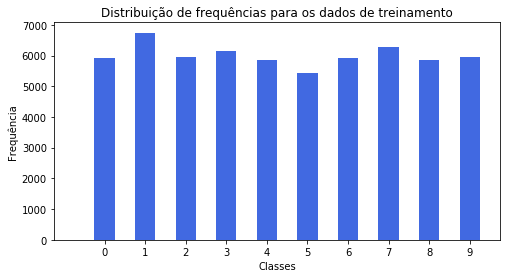

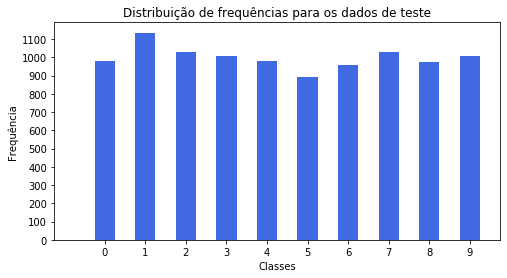

In [8]:
plot_hist(Y_categorical, titleText='Distribuição de frequências para os dados de treinamento', ymax=10000, step=1000);
plot_hist(Ytest_categorical, titleText='Distribuição de frequências para os dados de teste', ymax=1200, step=100);

<a id="visualizacao_imagens"></a>
- **Visualização de imagens de dígitos manuscritos**

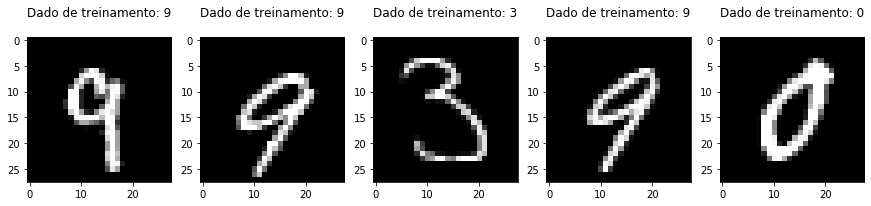

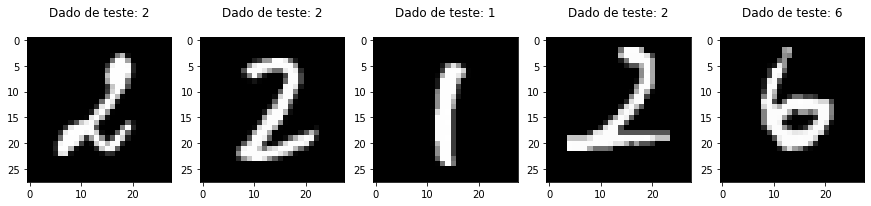

In [9]:
plot_digit_images(X, Y_categorical, titlesText='Dado de treinamento: ', Nimgs=5)
plot_digit_images(Xtest, Ytest_categorical, titlesText='Dado de teste: ', Nimgs=5)

-----------------------------------------------------------------
<a id="conjunto_treinamento_validacao"></a>
### Conjuntos de treinamento e validação

<a id="validacao_cruzada"></a>
- **Validação cruzada**
    - Para aumentar a **capacidade de generalização** do modelo, é utilizado a estratégia de validação cruzada conhecida por ***holdout***, em que dividimos as amostras de treinamento da seguinte forma:
        - Conjunto de treinamento: p% das amostras são utilizadas para treinar o modelo, de modo a produzir um classificador.
        - Conjunto de validação: (1-p)% das amostras são utilizadas para validar o modelo gerado, isto é, são utilizadas na etapa de análise de desempenho.
        - Nesta atividade, 80% das amostras de {$X$, $Y$} formam o conjunto de treinamento e 20% formam o conjunto de validação, como pode ser verificado na execução a seguir.

In [10]:
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.2, random_state=42)

In [11]:
print(f'Dimensão da matriz Xtrain: {Xtrain.shape}')
print(f'Dimensão da matriz Ytrain: {Ytrain.shape}')
print('--------------------------------------')
print(f'Dimensão da matriz Xval: {Xval.shape}')
print(f'Dimensão da matriz Yval: {Yval.shape}')

Dimensão da matriz Xtrain: (48000, 784)
Dimensão da matriz Ytrain: (48000, 10)
--------------------------------------
Dimensão da matriz Xval: (12000, 784)
Dimensão da matriz Yval: (12000, 10)


<a id="dados_balanceados_representativos"></a>
- **Dados balanceados e representativos**
    - Uma importante característica que devemos manter nos dois novos conjuntos é o **balanceamento entre as classes**, para que os dados utilizados tanto no conjunto de treinamento quanto no de validação sejam bastante **representativos** do problema.
    - O objetivo desta etapa é produzir modelos pouco **enviesados**.
    - Deste modo, podemos observar as distribuições de frequência dos dois conjuntos para investigar a proporção de amostras de cada uma das classes nos dois conjuntos citados.
    - Como pode ser observado nos resultados abaixo, a proporção de dados por classe em ambos os conjuntos está em um valor adequado.

In [12]:
Ytrain_categorical = np.array(tuple(map(onehot_to_categorical, Ytrain)))
Yval_categorical = np.array(tuple(map(onehot_to_categorical, Yval)))

Representação das classes no conjunto de treinamento:
Classe 0:  9.89%
Classe 1:  11.29%
Classe 2:  9.97%
Classe 3:  10.23%
Classe 4:  9.72%
Classe 5:  8.99%
Classe 6:  9.88%
Classe 7:  10.35%
Classe 8:  9.77%
Classe 9:  9.91%


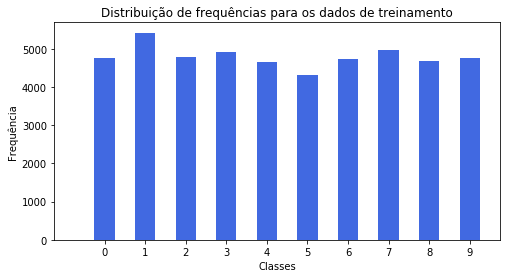

In [13]:
aux_train = plot_hist(Ytrain_categorical, titleText='Distribuição de frequências para os dados de treinamento', ymax=10000, step=1000)

aux = aux_train[0]
aux = aux[1:len(aux):2]
aux = aux*100/Xtrain.shape[0]
print('Representação das classes no conjunto de treinamento:')
for i in range(len(aux)):
    print(f'Classe {i}:  {round(aux[i],2)}%')

Representação das classes no conjunto de treinamento:
Classe 0:  9.79%
Classe 1:  11.02%
Classe 2:  9.78%
Classe 3:  10.16%
Classe 4:  9.8%
Classe 5:  9.2%
Classe 6:  9.81%
Classe 7:  10.82%
Classe 8:  9.67%
Classe 9:  9.95%


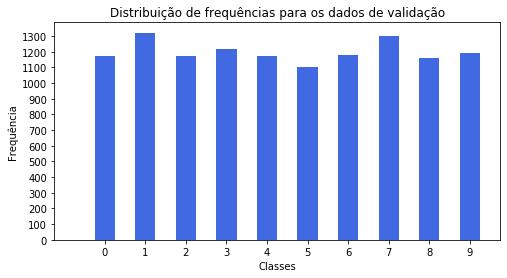

In [14]:
aux_val = plot_hist(Yval_categorical, titleText='Distribuição de frequências para os dados de validação', ymax=1500, step=100);

aux = aux_val[0]
aux = aux[1:len(aux):2]
aux = aux*100/Xval.shape[0]
print('Representação das classes no conjunto de treinamento:')
for i in range(len(aux)):
    print(f'Classe {i}:  {round(aux[i],2)}%', )

-----------------------------------------------------------------
<a id="modelo_linear"></a>
### Classificador Linear

<a id="modelo_regressao"></a>
- **Modelo de Regressão Linear**

    - Nesta atividade utilizaremos o modelo de regressão linear de múltiplas saídas como um classificador linear.

    - Considere o conjunto de amostras $ \{\textbf{x}(i), \textbf{y}(i)\}_{i=0}^{N-1}$ em que $\textbf{x} \in \mathbf{R}^K$ e $\textbf{y} \in \mathbf{R}^L$.
    - As saídas estimadas pelo modelo são representadas por $\hat{\textbf{y}} \in \mathbf{R}^L$.
    - Cada saída é dada pela combinação linear entre seus parâmetros ajustáveis e os atributos dos dados de entrada.
    - Considerando todas as $\textbf{N}$ amostras, o modelo de regressão linear de múltiplas saídas assume a seguinte forma:
&nbsp;
$$\begin{bmatrix} \hat{y}_0(\textbf{x}(0)) & \hat{y}_1(\textbf{x}(0)) & \ldots & \hat{y}_{L-1}(\textbf{x}(0)) \\ \hat{y}_0(\textbf{x}(1)) & \hat{y}_1(\textbf{x}(1)) & \ldots & \hat{y}_{L-1}(\textbf{x}(1)) \\ \vdots & \vdots & \ddots & \vdots \\ \hat{y}_0(\textbf{x}(N-1)) & \hat{y}_1(\textbf{x}(N-1)) & \ldots & \hat{y}_{L-1}(\textbf{x}(N-1)) \end{bmatrix}
= 
\begin{bmatrix} 1 & x_1(0) & ... & x_K(0) \\1 & x_1(1) & ... & x_K(1) \\ \vdots & \vdots & \ddots & \vdots \\ 1 & x_1(N-1) & ...& x_K(N-1) \\ \end{bmatrix}
\begin{bmatrix} w_0^{(0)} & w_0^{(1)} & \ldots & w_0^{(L-1)} \\ w_1^{(0)} & w_1^{(1)} & \ldots & w_1^{(L-1)} \\ \vdots & \vdots & \ddots & \vdots \\ w_K^{(0)} & w_K^{(1)} & ... & w_K^{(L-1)} \end{bmatrix}$$
&nbsp;
    em que as matrizes acima são, respectivamente, $\hat{Y}$, $\Phi$ e $W$. Desta forma, temos:
$$ \hat{Y} = \Phi\textbf{W} $$
    - Observações:
        - Cada linha das matriz $\hat{Y}$ contém as $\textbf{L}$ saídas estimadas de uma amostra.
        - Cada linha da matriz $\Phi$ contém os $\textbf{K}$ atributos de uma amostra.
        - A primeira coluna da matriz $\Phi$ é referente ao termo de bias do modelo.
        - Cada coluna da matriz $W$, o qual contém os parâmetros ajustáveis do modelo, faz um mapeamento entre as amostras e cada uma das saídas.
        - Há ainda a matriz de saídas desejadas $Y$ da forma:
$$\textbf{Y}=\begin{bmatrix}y_0(\textbf{x}(0)) & y_1(\textbf{x}(0)) & \ldots & y_{L-1}(\textbf{x}(0)) \\y_0(\textbf{x}(1)) & y_1(\textbf{x}(1)) & \ldots & y_{L-1}(\textbf{x}(1)) \\\vdots & \vdots & \ddots & \vdots \\y_0(\textbf{x}(N-1)) & y_1(\textbf{x}(N-1)) & \ldots & y_{L-1}(\textbf{x}(N-1)) \end{bmatrix}$$
    - Em regressão, o objetivo é obter um modelo que produza saídas estimadas $\hat{Y}$ mais próximas possíveis das saídas desejadas $Y$. 
    - A maneira mais comum de expressar matematicamente esse objetivo em problemas de regressão é por meio do uso do **Critério de Quadrados Mínimos**.
$$ min \; J_e(\textbf{W})$$
    onde $J_e(\textbf{W})$ indica o erro quadrático médio entre as saídas desejadas e conhecidas.
    - Logo, o problema de regressão se resume em minimizar o erro quadrático médio $J_e(\textbf{W})$: 
$$J_e(\textbf{W}) = \frac{1}{NL}\sum_{i=0}^{N-1}\sum_{k=0}^{L-1}[y_k(i)-\hat{y}_k(i)]^2$$
&nbsp;
    - Se $N > K+1$ e a matriz $\Phi$ tiver posto completo, a solução do problema de otimização é:
$$ \textbf{W} = (\Phi^T\Phi)^{-1}\Phi^T\textbf{Y}$$
&nbsp;
    - Modelo Linear Regularizado
        - Se $N > K+1$ e a matriz $\Phi$ não tiver posto completo, a matriz $\Phi^T\Phi$ não é invertível. Portanto, a solução anterior não é válida.
        - Pode-se resolver esse problema utilizando a técnica de regularização *Ridge Regression*, em que aplicamos um termo de penalização proporcional à norma da matriz de parâmetros $W$. 
$$ min \; [J_e(\textbf{W})-\lambda\parallel\textbf{W}\parallel]$$
&nbsp;
        - O novo problema de otimização apresenta a seguinte solução:
$$\textbf{W} = (\Phi^T\Phi+\lambda \textbf{I'})^{-1}\Phi^T\textbf{Y}$$
&nbsp;
        onde $\lambda>0$ é o coeficiente de regularização e 
$$\textbf{I'}=\begin{bmatrix} 0 & 0 & \ldots & 0 \\0 & 1 & \ldots & 0 \\\vdots & \vdots & \ddots & \vdots \\0 & 0 & \ldots & 1\end{bmatrix}$$

<a id="consideracoes"></a>
- **Considerações para utilizar o modelo de Regressão como Classificador Linear**
    - Cada coluna das matrizes $Y$ e $\hat{Y}$ corresponde a uma classe.
    - Cada coluna de $W$ corresponde a um classificador, de modo que cada um deles é responsável por produzir uma saída referente a uma das classes do problema.
    - Novamente, as saídas desejadas de cada amostra (linhas de $Y$) estão na representação *one-hot encoding*.
    - As saídas estimadas de cada amostra (linhas de $\hat{Y}$) são números reais.
    - Para definir a classe estimada pelo classificador linear a partir dos números reais gerados na saída, consideraremos que a classe estimada é aquela associada ao maior valor produzido.

In [15]:
class LinearClassifier():
    
    def __init__(self, Xtrain, Ytrain, Xpred, Ypred):
        self.Xt = Xtrain
        self.Yt = Ytrain
        self.Xp = Xpred
        self.Yp = Ypred
        [self.Nt, self.K] = Xtrain.shape
        self.Np = Xpred.shape[0]

        # variáveis de treinamento:
        self.Im = np.insert(np.insert(np.eye(self.K), 0, np.zeros([1, self.K]), axis=0), 0, np.zeros([1, self.K+1]), axis=1)
        self.Phi_t = np.insert(self.Xt, 0, np.ones([1, self.Nt]), axis=1)
        self.W = None
        
        # variáveis de predição
        self.Phi_p = np.insert(self.Xp, 0, np.ones([1, self.Np]), axis=1)
        self.Yest = None  # saídas estimadas na predição
        self.Yest_onehot = None # saídas estimadas na predição dadas na representação one-hot encoding
    
    def fit(self, coefReg):
        self.W = np.linalg.inv(np.transpose(self.Phi_t).dot(self.Phi_t) + coefReg*self.Im).dot(np.transpose(self.Phi_t).dot(self.Yt))
    
    def predict(self):
        self.Yest = self.Phi_p.dot(self.W)
        LinearClassifier.onehotencoding(self)
        
    def onehotencoding(self):
        # Cria uma matriz de saídas estimadas na representação one-hot encoding:
        self.Yest_onehot = self.Yest.copy()
        for i in range(0, self.Yest_onehot.shape[0]):   
            np.place(self.Yest_onehot[i], self.Yest_onehot[i] < np.max(self.Yest_onehot[i]), 0)
            np.place(self.Yest_onehot[i], self.Yest_onehot[i] == np.max(self.Yest_onehot[i]), 1)


<a id="param_desempenho"></a>
- **Parâmetros de desempenho**
    - Duas métricas são utilizadas para analisar o desempenho do classificador linear: erro quadrático médio e erro de classificação.
    - Erro Quadrático Médio (MSE):
$$MSE = \frac{1}{NL}\sum_{i=0}^{N-1}\sum_{k=0}^{L-1}[y_k(i)-\hat{y}_k(i)]^2$$
    - Taxa de Erro de Classificação (CE):
$$ CE = \frac{N_{erro}}{N} $$
&nbsp;

    onde $N_{erro}$ indica o número de amostras classificadas incorretamente.    

In [16]:
class Metrics():
    
    def __init__(self, Y, Yest, Yest_onehot):
        self.Y = Y
        self.Yest = Yest
        self.Yest_onehot = Yest_onehot
        
        self.MSE = None
        self.CE = None
    
    def meansquared_error(self):
        e = (self.Y - self.Yest)**2
        self.MSE = np.sum(np.sum(e, axis=1), axis=0) # / (N*L), onde [N, L] = self.Yval.shape
        return self.MSE
    
    def classification_error(self):
        matches = []
        
        for i in range(0, self.Y.shape[0]):
            matches.append(np.array_equal(self.Y[i], self.Yest_onehot[i]))
        
        score = matches.count(True)
        err = self.Y.shape[0] - score
        self.CE = err/(err + score)
        return self.CE

-----------------------------------------------------------------
<a id="resolucao"></a>
### Resolução do problema

- Inicialmente será feito uma busca pelos coeficientes de regularização $\lambda$, entre os valores abaixo, que levem aos menores valores de erro quadrático médio e taxa de erro de classificação. 
$$ A = \{2^{-10},\; 2^{-8}, \ldots,\; 2^{0},\; 2^{+2},\ldots,\; 2^{+10} \}$$
&nbsp;
    - Para cada $\lambda$ do conjunto $A$:
        - Treinar o modelo (obter a matriz $W$) com os dados de treinamento.
        - Estimar as saídas $\hat{Y}$ para os dados de validação.
        - Calcular e armazenar o erro quadrático médio e o erro de classificação para os dados de validação.
    - Os resultados são reportados por meio de gráficos semilog do desempenho dos classificadores junto aos dados de validação.
&nbsp;


- Em seguida, será feita uma busca refinada entorno dos dois coeficientes de regularização obtidos anteriormente.
    - Implementar o mesmo algoritmo acima.
&nbsp;


- Para o coeficiente de regularização que levou ao melhor desempenho associado ao erro de classificação:
    - Treinar o modelo com todos os dados de treinamento (conjunto de 60.000 amostras)
    - Estimar as saídas $\hat{Y}$ para os dados de teste.
    - Resultados:
        - Obter a matriz de parâmetros $W$.
        - Um gráfico de calor para os parâmetros de cada um dos 10 classificadores lineares.
        - Matriz de confusão do classificador quando aplicado ao conjunto de teste.
        - Exemplos de dados classificados incorretamente.

<a id="busca_inicial"> </a>
- **Etapa de treinamento e validação - Busca inicial pelos melhores coeficientes de regularização:**

In [17]:
# instancia da classe LinearClassifier utilizado nas etapas de treinamento e validação:
classifier = LinearClassifier(Xtrain, Ytrain, Xval, Yval)

<a id="A1"> </a>
- Treinamento e validação:

In [18]:
coefs = [2**n for n in range(-10, 21, 2)]

ms_errors = np.array([]) # Armazena os valores de erros quadráticos médios
ce_errors = np.array([]) # Armazena os valores de erros de classificação
best_coefs_MSE = []
best_coefs_CE = []

for coef in coefs:
    classifier.fit(coef) # treinamento
    classifier.predict() # validação
    
    desempenho = Metrics(Yval, classifier.Yest, classifier.Yest_onehot)
    
    ms_errors = np.append(ms_errors, desempenho.meansquared_error())
    ce_errors = np.append(ce_errors, desempenho.classification_error())

best_coefs_MSE.append(coefs[np.argmin(ms_errors)])  # melhor coef. de regularização considerando o erro quadrático médio
best_coefs_CE.append(coefs[np.argmin(ce_errors)])  # melhor coef. de regularização considerando o erro de classificação

<a id="A2"> </a>
- Melhores coeficientes de regularização obtidos:

In [19]:
ms_errors1 = ms_errors.copy()
ce_errors1 = ce_errors.copy()
print(f'Coeficiente de regularização para o menor erro quadrático médio: {best_coefs_MSE}')
print(f'Coeficiente de regularização para o menor erro de classificação: {best_coefs_CE}')

Coeficiente de regularização para o menor erro quadrático médio: [64]
Coeficiente de regularização para o menor erro de classificação: [1024]


<a id="A3"> </a>
- Gráfico semilog do desempenho dos classificadores junto aos dados de validação considerando o erro quadrático médio:

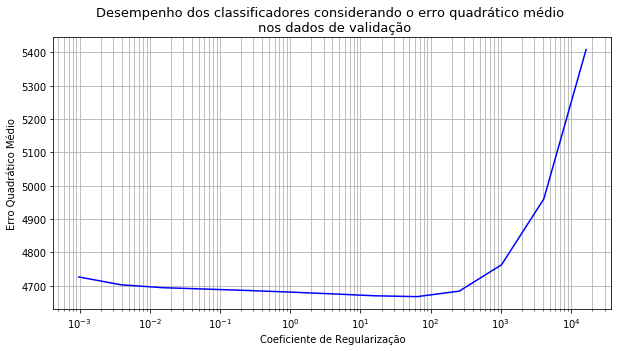

In [20]:
# coefs = [2**n for n in range(-10, 21, 2)]

plt.figure(figsize=(10,5))
plt.semilogx(coefs[0:13], ms_errors1[0:13], color='b')
plt.grid(True, which="both")
plt.xticks()
plt.title('Desempenho dos classificadores considerando o erro quadrático médio \n nos dados de validação', fontsize=13)
plt.xlabel('Coeficiente de Regularização')
plt.ylabel('Erro Quadrático Médio')
plt.show()

<a id="A4"> </a>
- Gráfico semilog do desempenho dos classificadores junto aos dados de validação consideranda taxa de classificação correta:

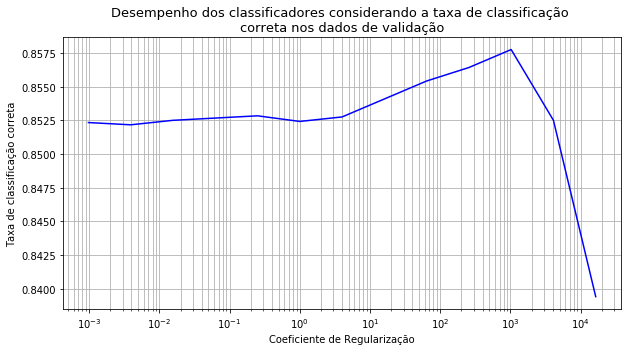

In [21]:
plt.figure(figsize=(10,5))
plt.semilogx(coefs[0:13], [1-erro for erro in ce_errors1[0:13]], color='b')
plt.grid(True, which="both")
plt.title('Desempenho dos classificadores considerando a taxa de classificação \ncorreta nos dados de validação', fontsize=13)
plt.xlabel('Coeficiente de Regularização')
plt.ylabel('Taxa de classificação correta')
plt.show()

<a id="A5"> </a>
- Gráfico semilog do desempenho dos classificadores junto aos dados de validação consideranda taxa de erro de classificação:

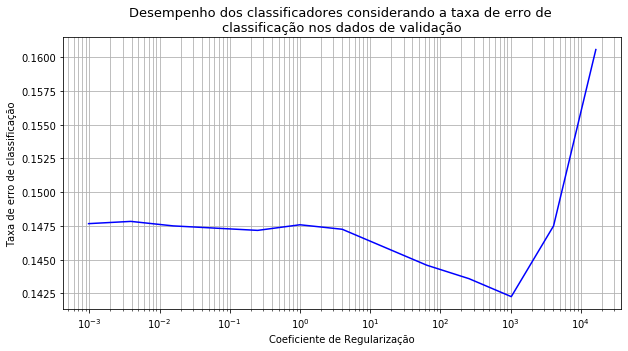

In [22]:
# coefs = [2**n for n in range(-10, 21, 2)]

plt.figure(figsize=(10,5))
plt.semilogx(coefs[0:13], ce_errors1[0:13], color='b')
plt.grid(True, which="both")
plt.title('Desempenho dos classificadores considerando a taxa de erro de \nclassificação nos dados de validação', fontsize=13)
plt.xlabel('Coeficiente de Regularização')
plt.ylabel('Taxa de erro de classificação')
plt.show()

<a id="busca_refinada_MSE"> </a>
- **Etapa de treinamento e validação - Busca refinada pelo melhor coeficiente de regularização considerando o erro quadrático médio**

<a id="B1"> </a>
- Treinamento e validação do modelo para 50 valores de $\lambda$ no intervalo $[10,10^3]$ espaçados logaritmicamente: 

In [23]:
coefs = np.logspace(1, 3, num=50)

ms_errors = np.array([]) # Armazena os valores de erros quadráticos médios

for coef in coefs:
    classifier.fit(coef) # treinamento
    classifier.predict() # validação
    
    desempenho = Metrics(Yval, classifier.Yest, classifier.Yest_onehot)
    ms_errors = np.append(ms_errors, desempenho.meansquared_error())
    
best_coefs_MSE.append(coefs[np.argmin(ms_errors)])

<a id="B2"> </a>
- Melhor coeficiente de regularização obtido:

In [24]:
ms_errors2 = ms_errors.copy()

print(f'Coeficiente de regularização para o menor erro quadrático médio: {best_coefs_MSE}')
print(f'Coeficiente de regularização para o menor erro de classificação: {best_coefs_CE}')

Coeficiente de regularização para o menor erro quadrático médio: [64, 49.417133613238335]
Coeficiente de regularização para o menor erro de classificação: [1024]


<a id="B3"> </a>
- Gráfico semilog do desempenho dos classificadores junto aos dados de validação considerando o erro quadrático médio:

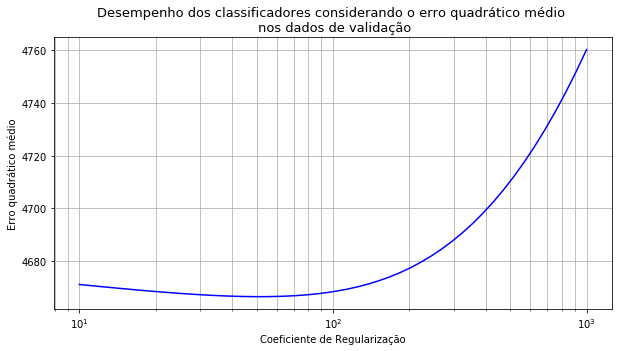

In [25]:
plt.figure(figsize=(10,5))
plt.semilogx(coefs, ms_errors2, color='b')
plt.grid(True, which="both")
plt.title('Desempenho dos classificadores considerando o erro quadrático médio \n nos dados de validação', fontsize=13)
plt.xlabel('Coeficiente de Regularização')
plt.ylabel('Erro quadrático médio')
plt.show()

<a id="busca_refinada_CE"> </a>
- **Etapa de treinamento e validação - Busca refinada pelo melhor coeficiente de regularização considerando o erro de classificação**

<a id="C1"> </a>
- Treinamento e validação do modelo para 100 valores de $\lambda$ no intervalo $[10^2,10^4]$ espaçados logaritmicamente: 

In [26]:
coefs = np.logspace(2, 4, num=100)

ce_errors = [] # Armazena os valores de erros de classificação

for coef in coefs:
    classifier.fit(coef) # treinamento
    classifier.predict() # validação
    
    desempenho = Metrics(Yval, classifier.Yest, classifier.Yest_onehot)
    ce_errors.append(desempenho.classification_error())

best_coefs_CE.append(coefs[np.argmin(ce_errors)])

<a id="C2"> </a>
- Melhor coeficiente de regularização obtido:

In [27]:
ce_errors2 = ce_errors.copy()

print(f'Coeficiente de regularização para o menor erro quadrático médio: {best_coefs_MSE}')
print(f'Coeficiente de regularização para o menor erro de classificação: {best_coefs_CE}')

Coeficiente de regularização para o menor erro quadrático médio: [64, 49.417133613238335]
Coeficiente de regularização para o menor erro de classificação: [1024, 977.0099572992257]


<a id="C3"> </a>
- Gráfico semilog do desempenho dos classificadores junto aos dados de validação consideranda taxa de classificação correta:

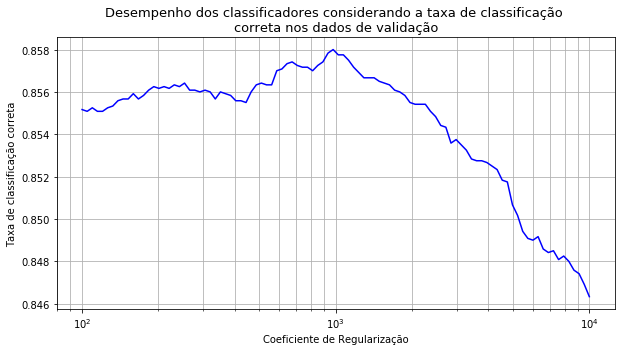

In [28]:
#coefs = np.logspace(2, 4, num=100)

plt.figure(figsize=(10,5))
plt.semilogx(coefs, [1-erro for erro in ce_errors2], color='b')
plt.grid(True, which="both")
plt.title('Desempenho dos classificadores considerando a taxa de classificação \ncorreta nos dados de validação', fontsize=13)
plt.xlabel('Coeficiente de Regularização')
plt.ylabel('Taxa de classificação correta')
plt.show()

<a id="C4"> </a>
- Gráfico semilog do desempenho dos classificadores junto aos dados de validação consideranda taxa de erro de classificação:

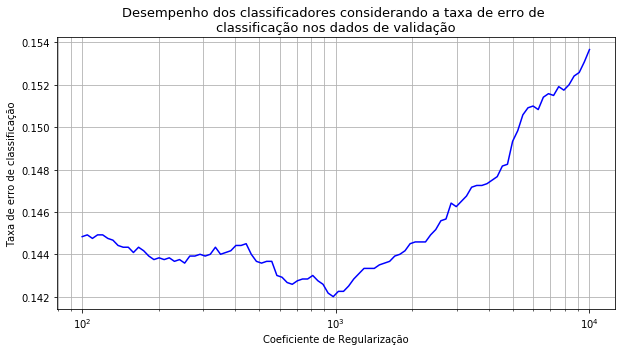

In [29]:
#coefs = np.logspace(2, 4, num=100)

plt.figure(figsize=(10,5))
plt.semilogx(coefs, ce_errors2, color='b')
plt.grid(True, which="both")
plt.title('Desempenho dos classificadores considerando a taxa de erro de \nclassificação nos dados de validação', fontsize=13)
plt.xlabel('Coeficiente de Regularização')
plt.ylabel('Taxa de erro de classificação')
plt.show()

<a id="teste"> </a>
- **Etapa de teste**

In [30]:
# instancia da classe LinearClassifier utilizado nas etapas de obtenção do modelo final e teste:
best_classifier = LinearClassifier(X, Y, Xtest, Ytest)

<a id="D1"> </a>
- Treinamento do modelo com os 60.000 dados de treinamento e predição com os 10.000 dados de teste

In [31]:
coef = best_coefs_CE[-1]

ms_errors = np.array([]) # Armazena os valores de erros quadráticos médios
ce_errors = np.array([]) # Armazena os valores de erros de classificação

best_classifier.fit(coef) #treinamento
best_classifier.predict()

desempenho = Metrics(Ytest, best_classifier.Yest, best_classifier.Yest_onehot)

ms_error = desempenho.meansquared_error()
ce_error = desempenho.classification_error()

<a id="D2"> </a>
- Matriz de Confusão

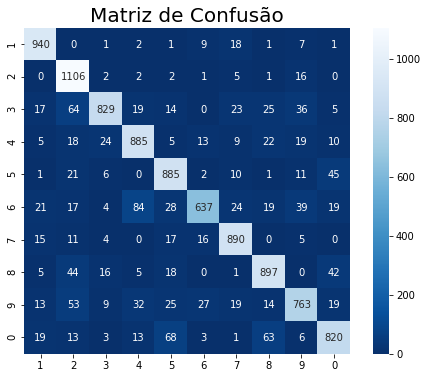

In [32]:
Ytest_categorical = np.array(tuple(map(onehot_to_categorical, Ytest)))
Yest_categorical = np.array(tuple(map(onehot_to_categorical, best_classifier.Yest_onehot)))

index = [i for i in "1234567890"]

plt.figure(figsize=(8, 6))
plt.title('Matriz de Confusão', fontsize=20)
plt.xlabel('Classes Verdadeiras')
plt.ylabel('Classes Estimadas')
sns.heatmap(confusion_matrix(Ytest_categorical, Yest_categorical), annot=True, annot_kws={'size': 10}, square=True, fmt='d', xticklabels=index, yticklabels=index, cmap='Blues_r');

<a id="D3"> </a>
- Matriz de parâmetros do modelo:

In [33]:
W = best_classifier.W
print(W.shape)

(785, 10)


<a id="D4"> </a>
- Gráficos de calor para os parâmetros de cada um dos 10 classificadores lineares:

In [34]:
Wk = np.transpose(np.delete(W, 0, axis=0))
Yk = list(range(1, 10))
Yk.append(0)

print(Wk.shape)
print(Yk)

(10, 784)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 0]


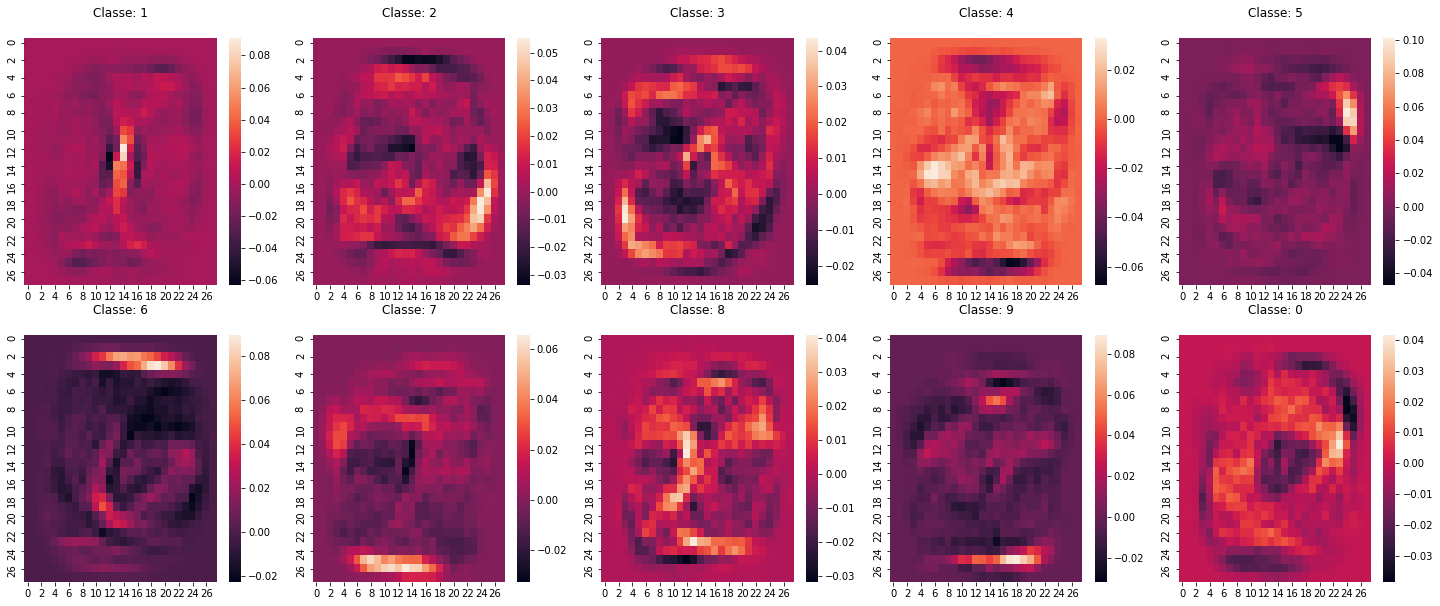

In [35]:
plt.figure(figsize=(25, 10))

for index, (w_vec, label) in enumerate(zip(Wk[0:10], Yk[0:10])):
    plt.subplot(2, 5, index + 1)
    W_image = np.transpose(np.reshape(w_vec, (28, 28)))
    sns.heatmap(W_image)
    plt.title('Classe: ' + f'{label}\n', fontsize = 12)

<a id="D5"> </a>
- Exemplos de dígitos classificados incorretamente: 

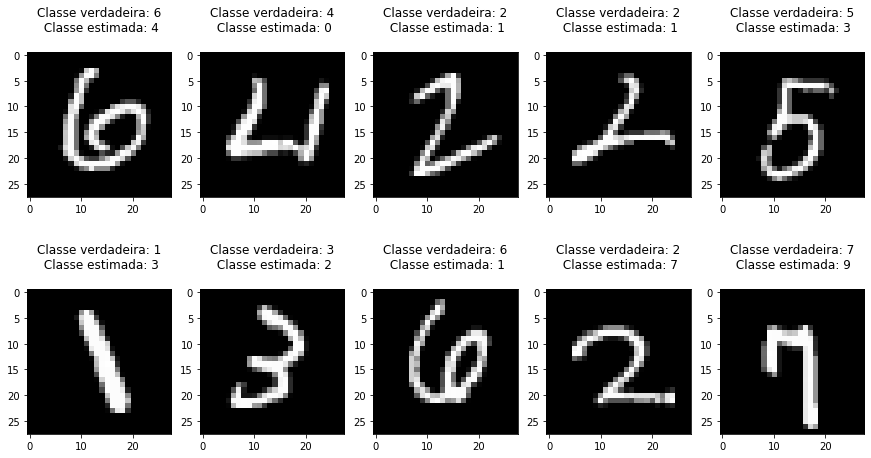

In [36]:
estErr = np.array([1 if imagem != 0 else 0 for imagem in Ytest_categorical-Yest_categorical])
indices = list(np.where(estErr == 1)[0])

plt.figure(figsize=(15,8))

N = 0

for index_subplot, index_amostra in enumerate(indices[N:N+10]):
    # print(index_subplot, index_amostra)
    plt.subplot(2, 5, index_subplot+1)
    X_image = np.transpose(np.reshape(Xtest[index_amostra], (28, 28)))
    plt.imshow(X_image, cmap='gray')
    plt.title(f'Classe verdadeira: {Ytest_categorical[index_amostra]}\n Classe estimada: {Yest_categorical[index_amostra]}\n')